# 설정

이 프로젝트에는 파이썬 3.7 이상이 필요합니다:

In [4]:
import sys

assert sys.version_info >= (3, 7)

또한 사이킷런 ≥ 1.0.1이 필요합니다:

In [5]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

이전 챕터에서 했던 것처럼 기본 글꼴 크기를 정의하여 그림을 더 예쁘게 만들어 보겠습니다:

In [6]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

그리고 `images/training_linear_models` 폴더(아직 존재하지 않는 경우)를 만들고, 이 노트북을 통해 책에 사용할 그림을 고해상도로 저장하는 데 사용되는 `save_fig()` 함수를 정의해 보겠습니다:

In [7]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "training_linear_models"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [9]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

In [13]:
import numpy as np

# 연습문제

## 조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀 구현하기
문제: _사이킷런을 사용하지 않고 넘파이만으로 조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀를 구현해 보세요. 이를 붓꽃 데이터셋과 같은 분류 작업에 사용해 보세요._

데이터를 로드하는 것부터 시작하겠습니다. 앞서 로드한 붓꽃 데이터셋을 재사용하겠습니다.

In [10]:

X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"].values

소프트맥스 함수는 다음 방정식으로 정의된다는 것을 기억하세요:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [11]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = exps.sum(axis=1, keepdims=True)
    return exps / exp_sums

Hint. 검증 세트에 대한 예측을 수행하고 정확도 점수를 확인해보세요.

조기 종료를 추가해보세요.

전체 데이터셋에 대한 모델의 예측을 그래프로 그려보세요(강의자료 참고, 모델에 주입하는 모든 특성의 크기를 조정하는 것을 잊지 마세요)

테스트 세트에서 모델의 정확도를 확인해보세요.



In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, add_dummy_feature

# Set random seed for reproducibility
np.random.seed(42)

# 1. Split data into training/validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Split training/validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2 of original data

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (90, 2)
X_val shape: (30, 2)
X_test shape: (30, 2)
y_train shape: (90,)
y_val shape: (30,)
y_test shape: (30,)


In [15]:
# 3. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"X_train_scaled shape: {X_train_scaled.shape}")

X_train_scaled shape: (90, 2)


In [16]:
# 4. Add bias term (x0 = 1) to input features
X_train_processed = add_dummy_feature(X_train_scaled)
X_val_processed = add_dummy_feature(X_val_scaled)
X_test_processed = add_dummy_feature(X_test_scaled)

print(f"X_train_processed shape: {X_train_processed.shape}")

X_train_processed shape: (90, 3)


In [17]:
# 5. One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False) # Use sparse_output=False for dense array output
y_train_one_hot = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_one_hot = encoder.transform(y_val.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.reshape(-1, 1))

print(f"y_train_one_hot shape: {y_train_one_hot.shape}")

y_train_one_hot shape: (90, 3)


In [18]:
def cross_entropy(Y_proba, Y_one_hot):
    # Add a small epsilon to avoid log(0) issues
    epsilon = 1e-10
    return -np.sum(Y_one_hot * np.log(Y_proba + epsilon), axis=1)

In [19]:
def accuracy(Y_proba, Y_one_hot):
    y_pred = np.argmax(Y_proba, axis=1)
    y_true = np.argmax(Y_one_hot, axis=1)
    return np.mean(y_pred == y_true)


In [20]:
np.random.seed(42)

n_inputs = X_train_processed.shape[1] # Number of features + bias term
n_outputs = y_train_one_hot.shape[1] # Number of classes

# Initialize model parameters (Theta) randomly
Theta = np.random.randn(n_inputs, n_outputs)

learning_rate = 0.1
n_epochs = 5001
patience = 50 # Number of epochs to wait before early stopping if validation loss doesn't improve
epochs_no_improve = 0
best_loss = float('inf')
best_Theta = None

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(n_epochs):
    # Calculate logits for training data
    logits = X_train_processed @ Theta
    # Calculate probabilities using softmax function
    Y_proba = softmax(logits)
    # Calculate gradients of the cross-entropy loss with respect to Theta
    # The gradient of the cross-entropy loss for softmax is (1/m) * X_T * (Y_proba - Y_one_hot)
    # In batch GD, we sum over all samples, so it's (1/m) * X_processed.T @ (Y_proba - y_train_one_hot)
    error = Y_proba - y_train_one_hot
    gradients = 1 / len(X_train_processed) * X_train_processed.T @ error

    # Update Theta using gradient descent
    Theta = Theta - learning_rate * gradients

    # Evaluate on training set
    train_logits = X_train_processed @ Theta
    train_proba = softmax(train_logits)
    train_loss = np.mean(cross_entropy(train_proba, y_train_one_hot))
    train_acc = accuracy(train_proba, y_train_one_hot)

    # Evaluate on validation set
    val_logits = X_val_processed @ Theta
    val_proba = softmax(val_logits)
    val_loss = np.mean(cross_entropy(val_proba, y_val_one_hot))
    val_acc = accuracy(val_proba, y_val_one_hot)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Early stopping logic
    if val_loss < best_loss:
        best_loss = val_loss
        best_Theta = Theta.copy() # Store a copy of the best parameters
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best validation loss: {best_loss:.4f}")
            break

print(f"Training finished. Last epoch: {epoch+1}")
print(f"Final Training Loss: {train_losses[-1]:.4f}, Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}, Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Restore best model parameters
Theta = best_Theta
print("Model restored to best validation performance.")

Training finished. Last epoch: 5001
Final Training Loss: 0.0981, Final Validation Loss: 0.1002
Final Training Accuracy: 0.9556, Final Validation Accuracy: 0.9667
Model restored to best validation performance.


In [21]:
val_logits = X_val_processed @ Theta
val_proba = softmax(val_logits)
val_accuracy = accuracy(val_proba, y_val_one_hot)
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

test_logits = X_test_processed @ Theta
test_proba = softmax(test_logits)
test_accuracy = accuracy(test_proba, y_test_one_hot)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Final Validation Accuracy: 0.9667
Final Test Accuracy: 1.0000


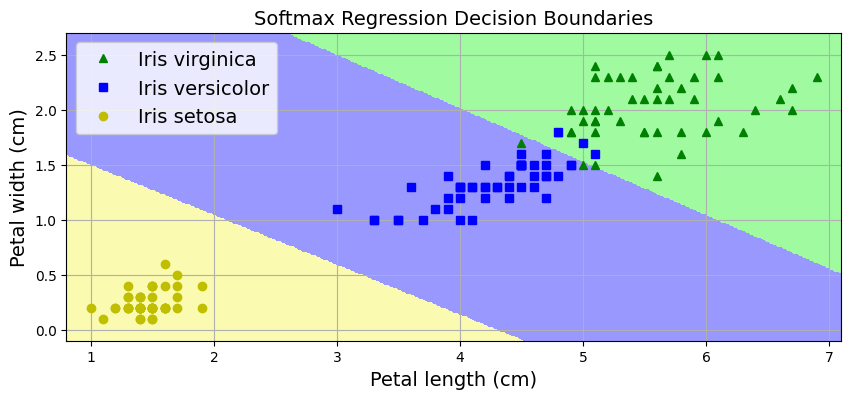

In [24]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(10, 4))

# Get min and max values for the features for plotting
x0_min, x0_max = X_train_scaled[:, 0].min(), X_train_scaled[:, 0].max()
x1_min, x1_max = X_train_scaled[:, 1].min(), X_train_scaled[:, 1].max()

# Create a meshgrid to plot decision boundaries
# We'll use a slightly larger range than the min/max of scaled training data for better visualization
x0, x1 = np.meshgrid(np.linspace(x0_min - 0.5, x0_max + 0.5, 500).reshape(-1, 1),
                     np.linspace(x1_min - 0.5, x1_max + 0.5, 200).reshape(-1, 1))

X_new_vis_scaled = np.c_[x0.ravel(), x1.ravel()]
X_new_vis_processed = add_dummy_feature(X_new_vis_scaled)

# Make predictions on the meshgrid
logits_vis = X_new_vis_processed @ Theta
y_proba_vis = softmax(logits_vis)
y_predict_vis = np.argmax(y_proba_vis, axis=1)

# Reshape predictions for contour plotting
zz = y_predict_vis.reshape(x0.shape)

# Unscale the meshgrid coordinates for plotting with original feature values
x0_unscaled = scaler.inverse_transform(np.c_[x0.ravel(), np.zeros_like(x0.ravel())])[:, 0].reshape(x0.shape)
x1_unscaled = scaler.inverse_transform(np.c_[np.zeros_like(x1.ravel()), x1.ravel()])[:, 1].reshape(x1.shape)

# Plot the decision boundary background
custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])
plt.contourf(x0_unscaled, x1_unscaled, zz, cmap=custom_cmap)

# Plot the data points (using the original unscaled X for X and y)
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.legend(loc="upper left")
plt.title("Softmax Regression Decision Boundaries")
plt.axis([X[:, 0].min() - 0.2, X[:, 0].max() + 0.2, X[:, 1].min() - 0.2, X[:, 1].max() + 0.2])
plt.grid()
plt.show()